Following the California Housing Project from the O'REILLY book Hands On Machine Learning with SciKit-Learn, Keras & TensorFlow.

# First Task

Using the California Housing Prices dataset from StatLib our task is to predict the median housing price for a block group.

The dataset includes metrics like population, median income, and median housing price at block group level.

This task lends itself to supervised learning as we have a labelled dataset, and the type of model will be a multiple linear regression, univariate model.

The dataset can be found on kaggle here - https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [2]:
# import our standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotx

In [33]:
# ML Specific Libraries focused on linear regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [4]:
# import our data
housing_df = pd.read_csv('../datasets/housing.csv')

In [5]:
# inspect our data
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
# check the value counts for the ocean_proximity column
housing_df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

# Notes on the data

- immediately we realise that there is a non-numeric feature - ocean proximity - which is categorical, we will need to explore how to deal with this data and its effect on our modelling.
- median_income seems to be scaled and capped at 15.000 - our understanding is that 1 = 1000. We will need to consider this carefully when going through feature selection and data transformations/scaling.
- median_house_value looks to be capped at 500001, this is a possible problem as it is the target value. How do we ensure the model does not restrict itself to this cap?
- households and population look like there may be some outliers to consider.
- total_bedrooms has null values which we will need to either fill or remove from the dataset

# Visualise the data

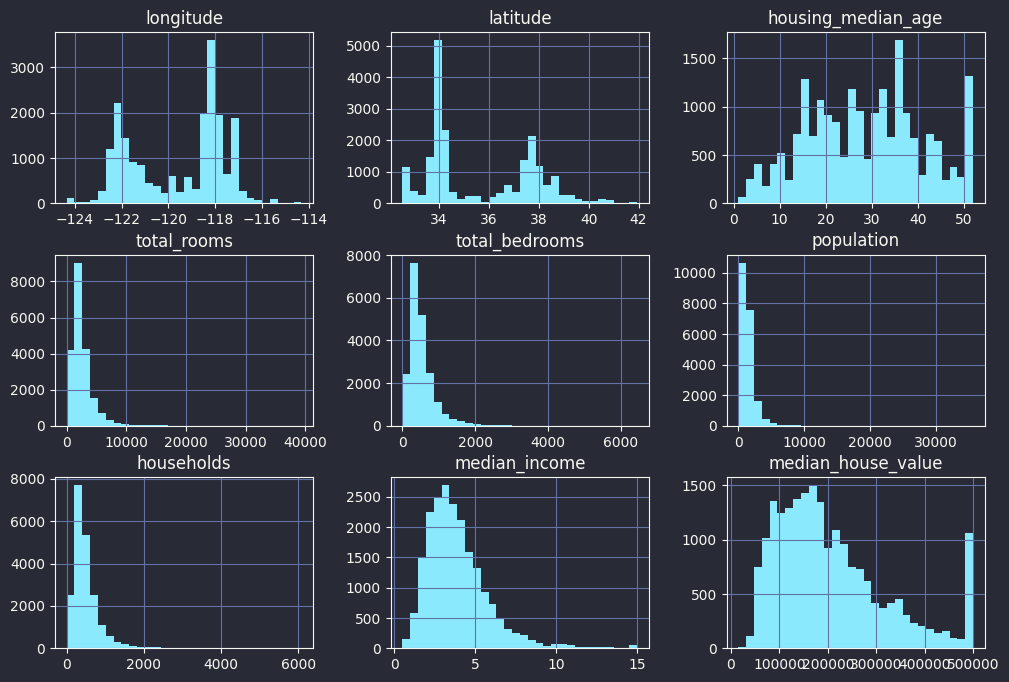

In [8]:
# use everywhere:
plt.style.use(matplotx.styles.dracula)
# plot histograms for each numeric column
housing_df.hist(bins=30, figsize=(12,8))
plt.show()

# Split the data

When splitting the data, we want to ensure there is no sampling bias, therefore, we will use stratified sampling to ensure the spread of data is representative across an important metric. For this dataset, median_income is likely a very important feature and we will categorise the data, check the value counts, then split the data.

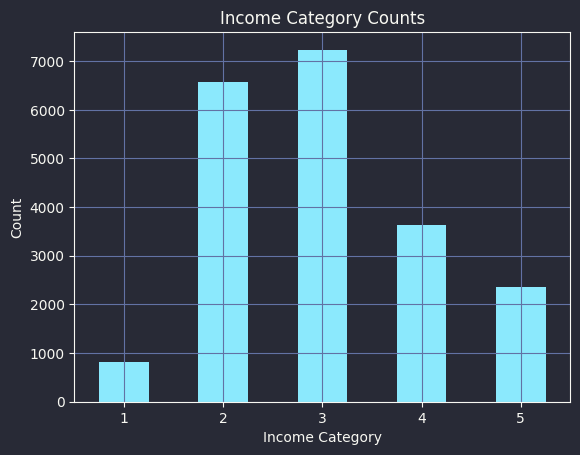

In [9]:
# create a new column for median_income categories with labels 1-5
housing_df['income_cat'] = pd.cut(housing_df['median_income'],
                                    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                    labels=[1, 2, 3, 4, 5])

# plot the value counts for the new column
housing_df['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income Category')
plt.ylabel('Count')
plt.title('Income Category Counts')
plt.show()

In [10]:
# Split the data into training and test sets with stratified sampling on the income category
train_set, test_set = train_test_split(housing_df, test_size=0.2, random_state=42, stratify=housing_df['income_cat'])

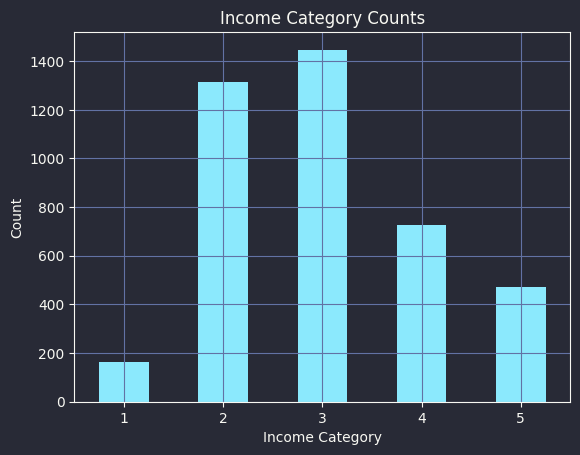

In [11]:
# let's see how the income category is distributed in the test set
test_set['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income Category')
plt.ylabel('Count')
plt.title('Income Category Counts')
plt.show()

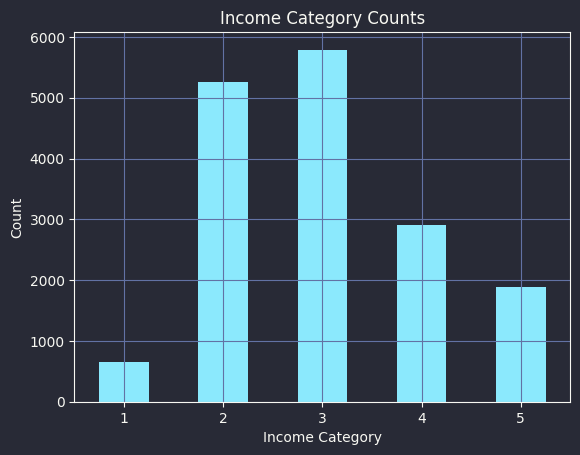

In [12]:
# let's see how the income category is distributed in the training set
train_set['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income Category')
plt.ylabel('Count')
plt.title('Income Category Counts')
plt.show()

The distribution of train and test set look very close which is exactly what we were looking for with the stratified split.

Moving forward, let's copy the training set as we may do a number of transformations to it before working on our features. After which we will continue working with the data.

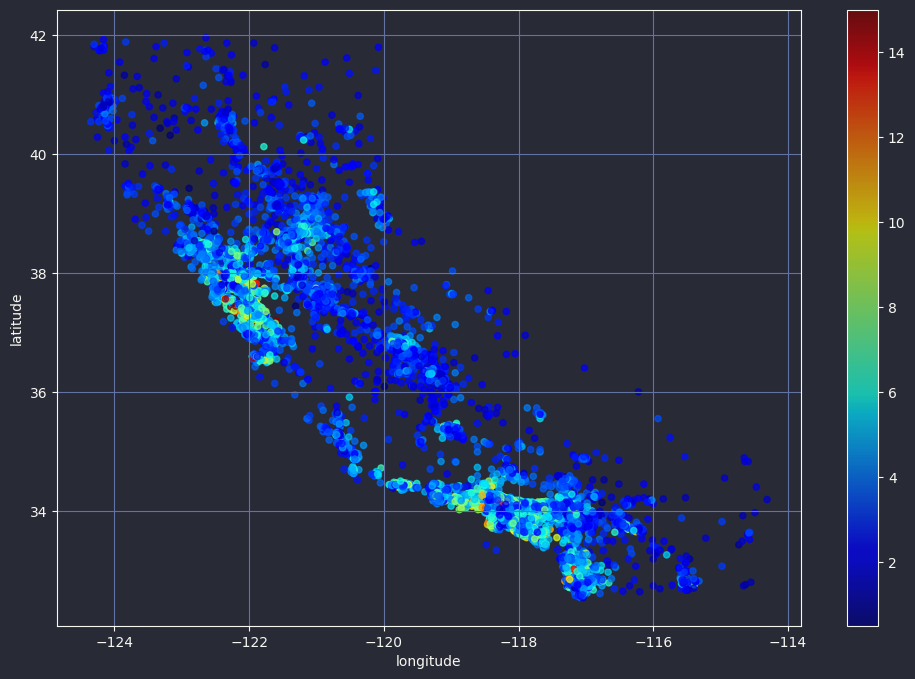

In [13]:
# copy the training set to a new dataframe
housing_train_df = train_set.copy()

# plot the latitude and longitude of the training set
train_set.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.7, c=train_set['median_income'], figsize=(12,8), cmap=plt.get_cmap('jet'))
plt.show()

# yes it looks like california, and a weather map - it was a bit of fun to mess around with the alpha and cmap parameters

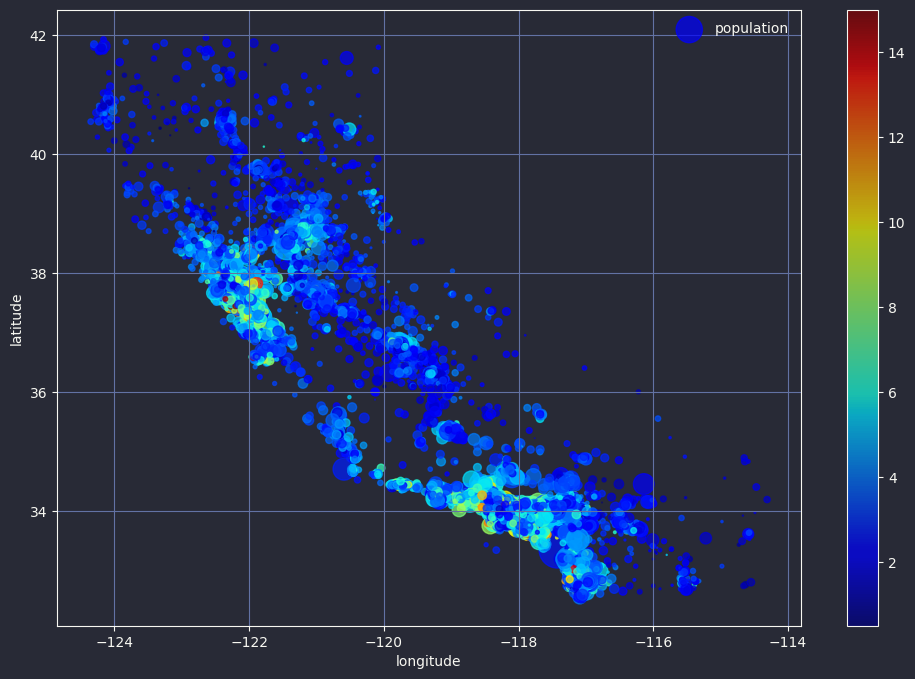

In [14]:
# let's expand on the visualization a bit, add the population size as a circle size
train_set.plot(kind='scatter', x='longitude', y='latitude', grid=True, alpha=0.7, c=train_set['median_income'], figsize=(12,8), cmap=plt.get_cmap('jet'), s=train_set['population']/50, label='population')
plt.legend()
plt.show()

Admittedly I got a little carried away playing with this theme, but it has highlighted areas of income density and population density.

In [15]:
# drop the income_cat and ocean_proximity columns from the training set
train_set = train_set.drop(['income_cat', 'ocean_proximity'], axis=1)

# let's look at the correlation matrix
corr_matrix = train_set.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

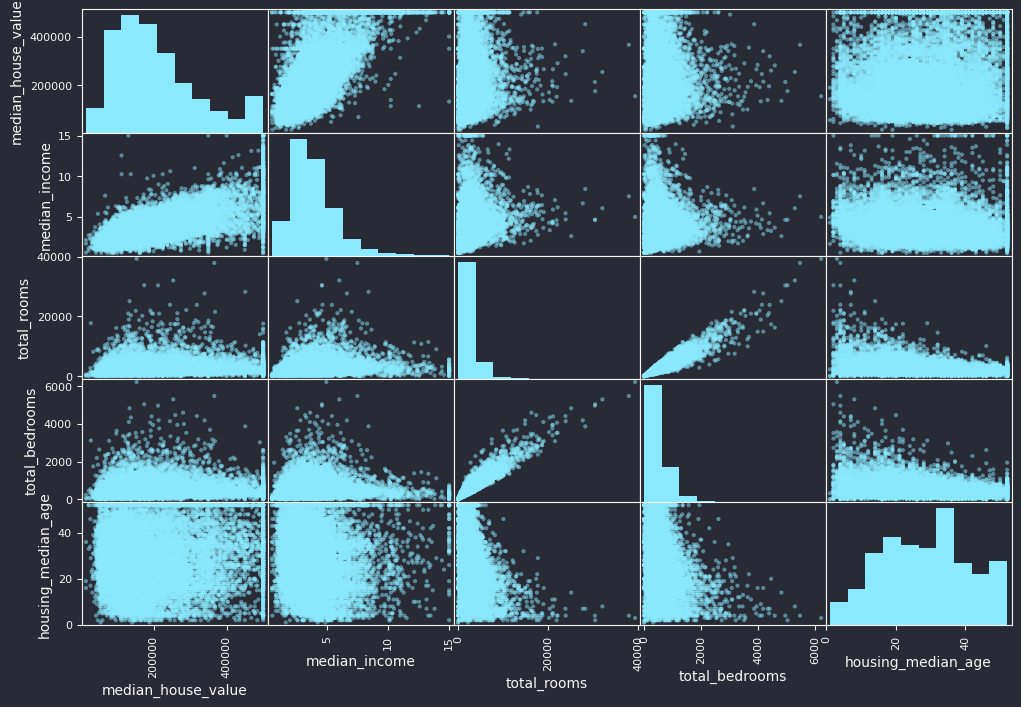

In [16]:
# let's take a look at some correlation plots
pd.plotting.scatter_matrix(train_set[['median_house_value', 'median_income', 'total_rooms', 'total_bedrooms', 'housing_median_age']], figsize=(12,8))
plt.show()

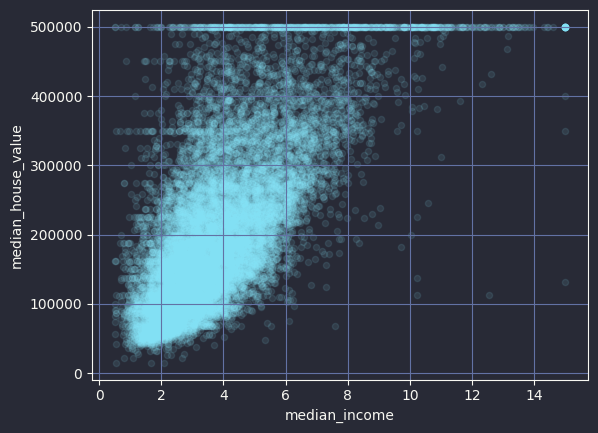

In [17]:
# median income and median house value warrants a closer look as it seems like there are some vertical lines
train_set.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
plt.show()

The plot above shows a clear upward trend and very clearly a housing value cap at 500k. We also notice a few clear horizontal lines at ~ 450k and 350k, may one a bit lower around 280k. These are quirks of the data and we do not want our model to have these quirks. Let's explore the data more to be sure of it, and possibly remove the quirks and check again.

With the density of the data between 50k and 180k we will do value counts over all the data, then filter down to data 180k and above. Once we identify the horizontal bars, we will remove those districts from our data.

In [18]:
# value counts across all training data
value_counts_df = train_set.median_house_value.value_counts().sort_values(ascending=False)

value_counts_df = value_counts_df.reset_index()
value_counts_df.head(30)

,median_house_value,count
0,500001.0,786
1,137500.0,102
2,162500.0,91
3,112500.0,80
4,187500.0,76
5,225000.0,70
6,350000.0,65
7,87500.0,59
8,150000.0,58
9,175000.0,52


In [19]:
# filter the value counts df where median house value is above 150
value_counts_df = value_counts_df[value_counts_df['median_house_value'] >= 150000 ]

value_counts_df.head(30)

,median_house_value,count
0,500001.0,786
2,162500.0,91
4,187500.0,76
5,225000.0,70
6,350000.0,65
8,150000.0,58
9,175000.0,52
12,275000.0,46
14,200000.0,40
15,250000.0,37


Visually we can double check these numbers against our plot. The top 16 values are horizontal quirks we want to remove from our data.

In [20]:
# take the first 16 values in value_counts_df for median_house_value and make them into a list
quirk_list = value_counts_df.median_house_value[:16].to_list()

# Flag the data we want to drop in our training data
train_set['drop_flag'] = train_set['median_house_value'].apply(lambda r: True if r in quirk_list else False)

train_set[train_set['drop_flag'] == True].head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,drop_flag
17989,-121.95,37.27,17.0,1330.0,271.0,408.0,258.0,1.7171,181300.0,True
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,500001.0,True
11493,-117.99,33.69,12.0,2480.0,858.0,1441.0,788.0,1.6705,350000.0,True
460,-122.26,37.87,52.0,1087.0,371.0,3337.0,350.0,1.4012,175000.0,True
769,-122.09,37.65,35.0,1184.0,200.0,572.0,194.0,4.7143,193800.0,True


In [21]:
train_set[train_set['drop_flag'] == False].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,drop_flag
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,False
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,False
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,False
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,False
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,False


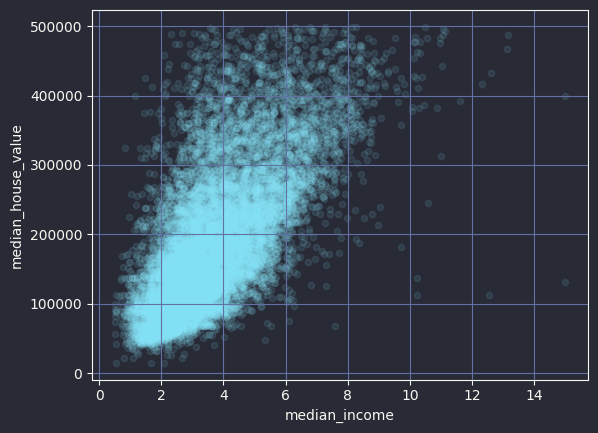

In [22]:
# Let's review the correlation now where drop_flag is equal to False
train_set[train_set['drop_flag'] == False].plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
plt.show()

the data looks alot cleaner after dropping those capped/estimated values. let's use this data going forward.

Our next steps are to do some feature engineering.

We want to add some features to the data set which enhance our ability to predict the house value.

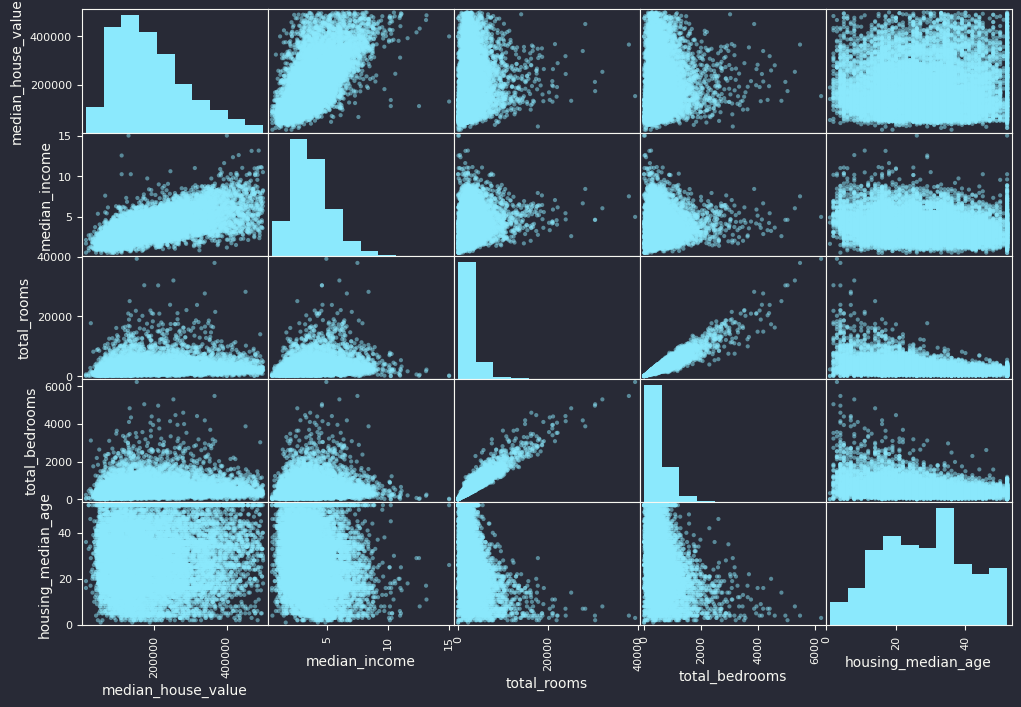

In [23]:
# drop the data
train_set.drop(train_set[train_set['drop_flag'] == True].index, inplace=True)
train_set.drop('drop_flag', axis=1, inplace=True)

# Another look at our scatter plots
pd.plotting.scatter_matrix(train_set[['median_house_value', 'median_income', 'total_rooms', 'total_bedrooms', 'housing_median_age']], figsize=(12,8))
plt.show()

In [24]:
# let's look at the correlation matrix
corr_matrix = train_set.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.670094
total_rooms           0.155206
households            0.101331
total_bedrooms        0.078918
housing_median_age    0.068369
population            0.017040
longitude            -0.039010
latitude             -0.156863
Name: median_house_value, dtype: float64

We have maintained the correlation when dropping the values, which is good. We also want to look more deeply into our very low correlated values - total bedrooms and total rooms. Let's engineer some new values which will make more sense to the algorithm and allow us to view the data differently.

We will engineer rooms per household, and bedrooms per household as it makes sense that higher value houses will have more of both of these attributes. At the moment, this is being hidden from us as each district has a different number of households and population.

In [25]:
# rooms per household
train_set['rooms_per_house'] = train_set['total_rooms'] / train_set['households']

# bedrooms per household
train_set['bedrooms_per_house'] = train_set['total_bedrooms'] / train_set['households']

# while we are at it, let's create population per household as it may assist in our understanding of results
train_set['population_per_household'] = train_set['population'] / train_set['households']

# add a bedroom to room ratio
train_set['bedrooms_ratio'] = train_set['total_bedrooms'] / train_set['total_rooms']

# let's see how the values shape up
train_set.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedrooms_per_house,population_per_household,bedrooms_ratio
count,15038.000000,15038.000000,15038.000000,15038.000000,14891.000000,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,14891.000000,15038.000000,14891.000000
mean,-119.564755,35.668234,28.295851,2647.610853,540.782419,1450.197766,502.814005,3.704874,190507.274704,5.391511,1.093755,3.085685,0.212082
std,2.006573,2.158995,12.434859,2154.688495,415.662836,1130.470008,378.010237,1.567940,97674.582408,2.114825,0.393392,11.274014,0.051845
min,-124.350000,32.540000,1.000000,6.000000,2.000000,8.000000,2.000000,0.499900,14999.000000,1.130435,0.531250,0.692308,0.100000
25%,-121.750000,33.930000,18.000000,1463.000000,299.000000,806.000000,284.000000,2.554325,113800.000000,4.465610,1.005499,2.456801,0.176917
50%,-118.540000,34.280000,28.000000,2134.000000,437.000000,1189.500000,412.000000,3.493700,170750.000000,5.223049,1.047859,2.843308,0.203264
75%,-117.990000,37.730000,37.000000,3152.750000,648.000000,1750.000000,606.000000,4.615300,246075.000000,5.987225,1.097561,3.303857,0.238056
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,499100.000000,62.422222,15.312500,1243.333333,0.922414


In [26]:
# great let's look at correlation again
corr_matrix = train_set.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.670094
total_rooms                 0.155206
rooms_per_house             0.132870
households                  0.101331
total_bedrooms              0.078918
housing_median_age          0.068369
population                  0.017040
population_per_household   -0.025762
longitude                  -0.039010
bedrooms_per_house         -0.074216
latitude                   -0.156863
bedrooms_ratio             -0.271203
Name: median_house_value, dtype: float64

Our bedrooms ratio has a much higher correlation to house value and all our per house values show better correlation than their sum values.

Great, we are almost ready to start training our data!

In [27]:
# inspect our data!
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15038 entries, 12655 to 19773
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 15038 non-null  float64
 1   latitude                  15038 non-null  float64
 2   housing_median_age        15038 non-null  float64
 3   total_rooms               15038 non-null  float64
 4   total_bedrooms            14891 non-null  float64
 5   population                15038 non-null  float64
 6   households                15038 non-null  float64
 7   median_income             15038 non-null  float64
 8   median_house_value        15038 non-null  float64
 9   rooms_per_house           15038 non-null  float64
 10  bedrooms_per_house        14891 non-null  float64
 11  population_per_household  15038 non-null  float64
 12  bedrooms_ratio            14891 non-null  float64
dtypes: float64(13)
memory usage: 1.6 MB


We have some null values to consider in total_bedrooms field. We have 3 options to transform this data and it's corresponding information.

1. Get rid of the rows where NA is true
2. Get rid of the whole attribute(s)
3. Impute the information

We are going to impute this information, it does not destruct the dataset and can be done on the test and train data as part of the ML pipeline.

In [28]:
# instantiate the imputer
imputer = SimpleImputer(strategy='median')

# fit the imputer to the training set
imputer.fit(train_set)

SimpleImputer(strategy='median')

In [29]:
print(imputer.statistics_)
print(train_set.median().values)

[-1.18540000e+02  3.42800000e+01  2.80000000e+01  2.13400000e+03
  4.37000000e+02  1.18950000e+03  4.12000000e+02  3.49370000e+00
  1.70750000e+05  5.22304925e+00  1.04785894e+00  2.84330837e+00
  2.03264095e-01]
[-1.18540000e+02  3.42800000e+01  2.80000000e+01  2.13400000e+03
  4.37000000e+02  1.18950000e+03  4.12000000e+02  3.49370000e+00
  1.70750000e+05  5.22304925e+00  1.04785894e+00  2.84330837e+00
  2.03264095e-01]


In [30]:
# Great now let's transform the data to fill na values with the field's mean
X = imputer.transform(train_set)

imputed_df = pd.DataFrame(X, columns=train_set.columns, index= train_set.index)

In [31]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15038 entries, 12655 to 19773
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 15038 non-null  float64
 1   latitude                  15038 non-null  float64
 2   housing_median_age        15038 non-null  float64
 3   total_rooms               15038 non-null  float64
 4   total_bedrooms            15038 non-null  float64
 5   population                15038 non-null  float64
 6   households                15038 non-null  float64
 7   median_income             15038 non-null  float64
 8   median_house_value        15038 non-null  float64
 9   rooms_per_house           15038 non-null  float64
 10  bedrooms_per_house        15038 non-null  float64
 11  population_per_household  15038 non-null  float64
 12  bedrooms_ratio            15038 non-null  float64
dtypes: float64(13)
memory usage: 1.6 MB


Excellent, no more null values!

Earlier on we did away with some text data, we will need to incorporate this back into the data but to do that, we need to engineer it in such a way that it is numeric and our system can deal with it.

In [32]:
# get the housing categories from the housing_train_df *NB* use the train df we copied too that keeps an original set of training data before transforms
housing_cat = housing_train_df[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


These are not some random strings but clearly classifications of the data. We will encode them and join that data back onto the training set.

In [34]:
# instantiate a one hot encoder
cat_encoder = OneHotEncoder()

# fit and transform the encoder to the housing categories
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

# this creates a SciPy sparse matrix, very handy if we have alot of data as it only stores the location of the non-zero elements
# let's take a look at the matrix
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [35]:
# let's put this data into a dataframe and keep the index from housing_cat dataframe. We can do this by first converting the sparse matrix to a dense matrix, then converting the dense matrix to a dataframe
housing_cat_df = pd.DataFrame(housing_cat_1hot.toarray(), columns=cat_encoder.get_feature_names_out(), index=housing_cat.index)

housing_cat_df.head(10)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,0.0,1.0,0.0,0.0,0.0
15502,0.0,0.0,0.0,0.0,1.0
2908,0.0,1.0,0.0,0.0,0.0
14053,0.0,0.0,0.0,0.0,1.0
20496,1.0,0.0,0.0,0.0,0.0
1481,0.0,0.0,0.0,1.0,0.0
18125,1.0,0.0,0.0,0.0,0.0
5830,1.0,0.0,0.0,0.0,0.0
17989,1.0,0.0,0.0,0.0,0.0
4861,1.0,0.0,0.0,0.0,0.0


Excellent! Before we join the data and train, we can scale our numeric data sitting in imputed df. We are very close to bringing this all together!

Feature scaling is extremely important in machine learning, it ensures all of our numeric information is on a scale relative to one another. This removes bias which can occur when numeric values are orders of magnitude larger than others. If we do not scale the data, the weighting of importance the model gives each feature may be incorrect, causing bias or just a blatantly incorrect model.

There are different types of scalers and they work differently from one another, sometimes having different outputs. It is good to try and test different scalers, and understand them. MinMaxScaler is a common scaler which by default results in values ranging from 0 to 1 - this can be changed though. StandardScaler is also common, and slightly more complex than MinMax, it does not restrict values to a certain range, but rather looks to standardize their distribution, making it less sensitive to outliers.

Before scaling the data though we need to inspect the shape of the data, it's distribution. We would like our data to represent a Gaussian distribution. Machine Learning models do not like data with heavy tails or multi-modal data.

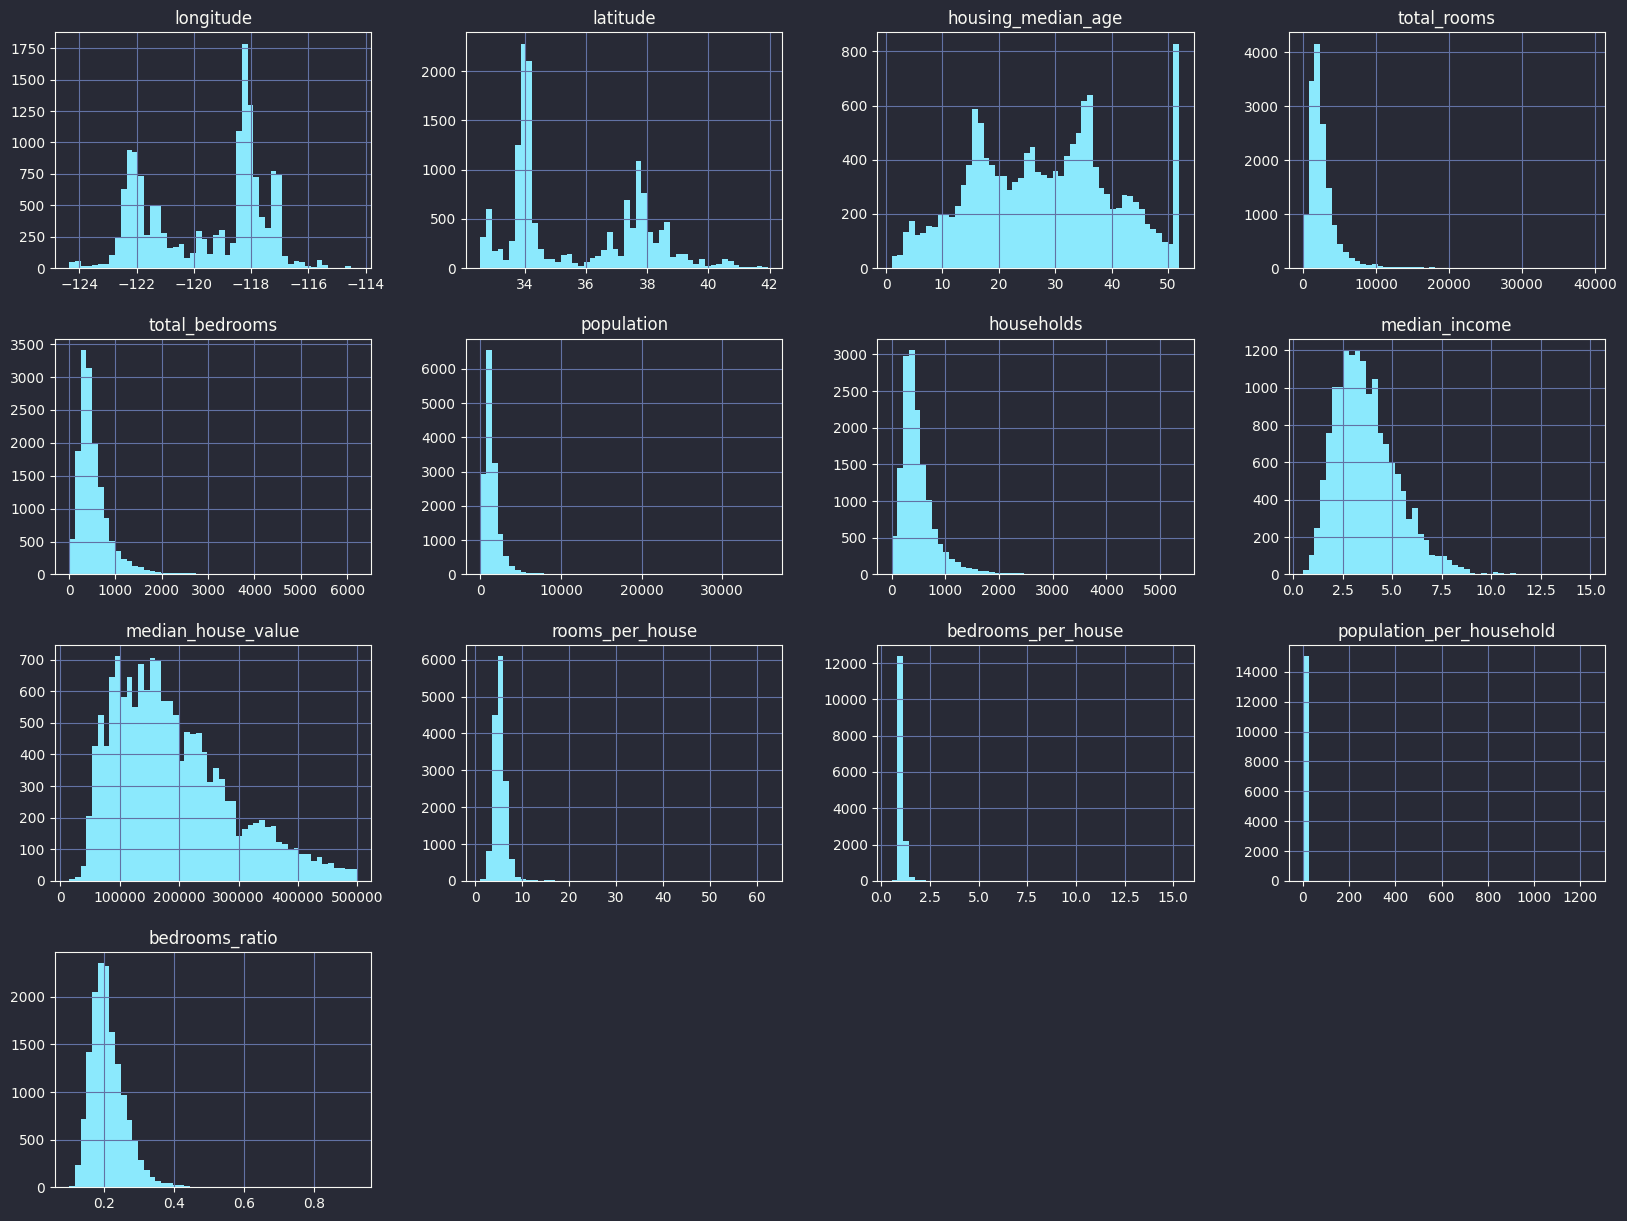

In [36]:
# plot histograms of all the fields in the imputed dataframe
imputed_df.hist(bins=50, figsize=(20,15))
plt.show()